German Traffic Sign Recognition Benchmark (GTSRB)
=================================================
---
Introduction au Deep Learning  (IDLE) - S. Aria, E. Maldonado, JL. Parouty - CNRS/SARI/DEVLOG - 2020

## Episode 3 : Tracking, visualizing and save models

Our main steps:
 - Monitoring and understanding our model training
 - Analyze the results 
 - Improving our model
 - Add recovery points


## 1/ Import and init

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard

import numpy as np
import h5py
import matplotlib.pyplot as plt
import os, time, random

import idle.pwk as ooo
from importlib import reload

ooo.init()

IDLE 2020 - Practical Work Module
  Version            : 0.1.4
  Run time           : Monday 13 January 2020, 21:13:18
  Matplotlib style   : idle/talk.mplstyle
  TensorFlow version : 2.0.0
  Keras version      : 2.2.4-tf


## 2/ Reload dataset
Dataset is one of the saved dataset: RGB25, RGB35, L25, L35, etc.  
First of all, we're going to use a smart dataset : **set-24x24-L**  
(with a GPU, it only takes 35'' compared to more than 5' with a CPU !)

In [2]:
%%time

dataset ='set-24x24-L'

# ---- Read dataset
#
filename='./data/'+dataset+'.h5'
with  h5py.File(filename) as f:
    x_train = f['x_train'][:]
    y_train = f['y_train'][:]
    x_test  = f['x_test'][:]
    y_test  = f['y_test'][:]

# ---- Dataset shape
#
(n,lx,ly,lz) = x_train.shape
data_shape   = (lx, ly, lz)

# ---- done
print('Dataset loaded ({:.1f} Mo)\n'.format(os.path.getsize(filename)/(1024*1024)))

Dataset loaded (228.8 Mo)

CPU times: user 0 ns, sys: 297 ms, total: 297 ms
Wall time: 294 ms


## 3/ Have a look to the dataset
Note: Data must be reshape for matplotlib

x_train :  (39209, 24, 24, 1)
y_train :  (39209,)
x_test  :  (12630, 24, 24, 1)
y_test  :  (12630,)


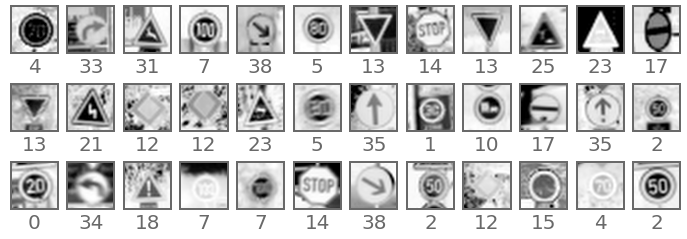

In [4]:
print("x_train : ", x_train.shape)
print("y_train : ", y_train.shape)
print("x_test  : ", x_test.shape)
print("y_test  : ", y_test.shape)

ooo.plot_images(x_train, y_train, range(36), columns=12, x_size=1, y_size=1)


## 4/ Create model
Some hyperparameters :

In [10]:
batch_size  =  64
num_classes =  43
epochs      =  8

My models :

In [32]:

def get_model_v1():
    model = keras.models.Sequential()
    model.add( keras.layers.Conv2D(96, (3,3), activation='relu', input_shape=(lx,ly,lz)))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Conv2D(192, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Flatten()) 
    model.add( keras.layers.Dense(500, activation='relu'))
    model.add( keras.layers.Dense(500, activation='relu'))
    model.add( keras.layers.Dense(43, activation='softmax'))
    return model


In [33]:
# ---- The model I want to test..
#
model = get_model_v1()
model.summary()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 22, 22, 96)        960       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 11, 11, 96)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 9, 9, 192)         166080    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 192)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 500)               1536500   
_________________________________________________________________
dense_7 (Dense)              (None, 500)              

## 4/ Data augmentation

In [34]:
datagen = keras.preprocessing.image.ImageDataGenerator(featurewise_center=False,
                             featurewise_std_normalization=False,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10.)
datagen.fit(x_train[:2000])

## 5/ Run model

In [36]:
%%time

# ---- Shuffle train data
# x_train,y_train=ooo.shuffle_np_dataset(x_train,y_train)

# ---- Train
# Note: To be faster in our example, we take only 2000 values
#       but in the real world, we'd take the whole dataset!
#
history = model.fit(  
                      x_train[:2000], y_train[:2000],  
#                       datagen.flow(x_train[:2000], y_train[:2000], batch_size=batch_size),
#                       batch_size=batch_size,
                      epochs=epochs,
                      verbose=1,
                      validation_data=(x_test[:200], y_test[:200]))

# model.save('./run/models/last-model.h5')

Train on 2000 samples, validate on 200 samples
Epoch 1/8
2000/2000 [==============================] - 2s 767us/sample - loss: 0.2712 - accuracy: 0.9195 - val_loss: 1.0751 - val_accuracy: 0.7650
Epoch 2/8
2000/2000 [==============================] - 2s 829us/sample - loss: 0.2290 - accuracy: 0.9295 - val_loss: 1.1727 - val_accuracy: 0.7400
Epoch 3/8
2000/2000 [==============================] - 2s 906us/sample - loss: 0.1570 - accuracy: 0.9515 - val_loss: 1.0644 - val_accuracy: 0.8350
Epoch 4/8
2000/2000 [==============================] - 2s 896us/sample - loss: 0.1282 - accuracy: 0.9640 - val_loss: 1.0879 - val_accuracy: 0.8150
Epoch 5/8
2000/2000 [==============================] - 2s 913us/sample - loss: 0.0847 - accuracy: 0.9750 - val_loss: 1.1590 - val_accuracy: 0.8050
Epoch 6/8
2000/2000 [==============================] - 2s 920us/sample - loss: 0.0754 - accuracy: 0.9810 - val_loss: 1.2716 - val_accuracy: 0.8100
Epoch 7/8
2000/2000 [==============================] - 2s 930us/sample 